In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN, convert_feature_into_cyclic
import pickle 

def preprocess(data_original):
    data = data_original.copy()
    data['Year'] = data['DateTime'].dt.year
    data['Month'] = data['DateTime'].dt.month
    data['DayOfYear'] = data['DateTime'].dt.dayofyear
    data['DayOfWeek'] = data['DateTime'].dt.dayofweek
    data['WeekOfYear'] = data['DateTime'].dt.isocalendar().week
    data = convert_feature_into_cyclic(data, 'Year', data['Year'].max() - data['Year'].min())
    data = convert_feature_into_cyclic(data, 'Month', 12)
    data = convert_feature_into_cyclic(data, 'DayOfYear', 365)
    data = convert_feature_into_cyclic(data, 'DayOfWeek', 7)
    data = convert_feature_into_cyclic(data, 'WeekOfYear', 52)
    data.drop(columns=['Year', 'Month', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'DateTime'], inplace=True)
    return data

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#cities = pd.read_csv('../csvs/weather/cities.csv', sep=',')
#contries = pd.read_csv('../csvs/weather/countries.csv', sep=',')
raw_data = pd.read_parquet("../csvs/weather/daily_weather.parquet")
raw_data = raw_data[raw_data['city_name'] == 'Cape Town']
raw_data['DateTime']= pd.to_datetime(raw_data['date'])
raw_data = raw_data[['DateTime','avg_temp_c']]
#data_preprocessed = preprocess(data)
#data_preprocessed
raw_data

,DateTime,avg_temp_c
0,1973-01-02,20.5
1,1973-01-03,20.8
2,1973-01-14,24.8
3,1973-01-15,22.3
4,1973-01-22,19.5
...,...,...
17714,2023-09-01,13.4
17715,2023-09-02,12.4
17716,2023-09-03,11.5
17717,2023-09-04,11.4


In [40]:
# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)
descriptions = raw_data.drop(columns=['DateTime']).describe()
descriptions.rename(columns={'avg_temp_c': 'Average Temperature (C)'}, inplace=True)
descriptions.round(2).to_csv('../csv-descriptions/weather-stats.csv')
descriptions

,Average Temperature (C)
count,17719.00
mean,16.84
std,3.77
min,5.00
25%,13.80
50%,16.80
75%,19.80
max,29.80


In [2]:
split_index = int(len(raw_data) * 0.7)
raw_train = raw_data[:split_index]
raw_test = raw_data[split_index:]

In [30]:
raw_train

,DateTime,avg_temp_c
0,1973-01-02,20.5
1,1973-01-03,20.8
2,1973-01-14,24.8
3,1973-01-15,22.3
4,1973-01-22,19.5
...,...,...
12398,2009-02-09,22.6
12399,2009-02-10,21.1
12400,2009-02-11,23.8
12401,2009-02-12,24.3


In [3]:
train_preprocessed = preprocess(raw_train)
train_preprocessed

,avg_temp_c,YearSin,YearCos,MonthSin,MonthCos,DayOfYearSin,DayOfYearCos,DayOfWeekSin,DayOfWeekCos,WeekOfYearSin,WeekOfYearCos
0,20.5,-0.939693,0.34202,0.500000,0.866025,0.034422,0.999407,0.781831,0.623490,0.120537,0.992709
1,20.8,-0.939693,0.34202,0.500000,0.866025,0.051620,0.998667,0.974928,-0.222521,0.120537,0.992709
2,24.8,-0.939693,0.34202,0.500000,0.866025,0.238673,0.971100,-0.781831,0.623490,0.239316,0.970942
3,22.3,-0.939693,0.34202,0.500000,0.866025,0.255353,0.966848,0.000000,1.000000,0.354605,0.935016
4,19.5,-0.939693,0.34202,0.500000,0.866025,0.369725,0.929141,0.000000,1.000000,0.464723,0.885456
...,...,...,...,...,...,...,...,...,...,...,...
12398,22.6,-0.939693,0.34202,0.866025,0.500000,0.635432,0.772157,0.000000,1.000000,0.748511,0.663123
12399,21.1,-0.939693,0.34202,0.866025,0.500000,0.648630,0.761104,0.781831,0.623490,0.748511,0.663123
12400,23.8,-0.939693,0.34202,0.866025,0.500000,0.661635,0.749826,0.974928,-0.222521,0.748511,0.663123
12401,24.3,-0.939693,0.34202,0.866025,0.500000,0.674444,0.738326,0.433884,-0.900969,0.748511,0.663123


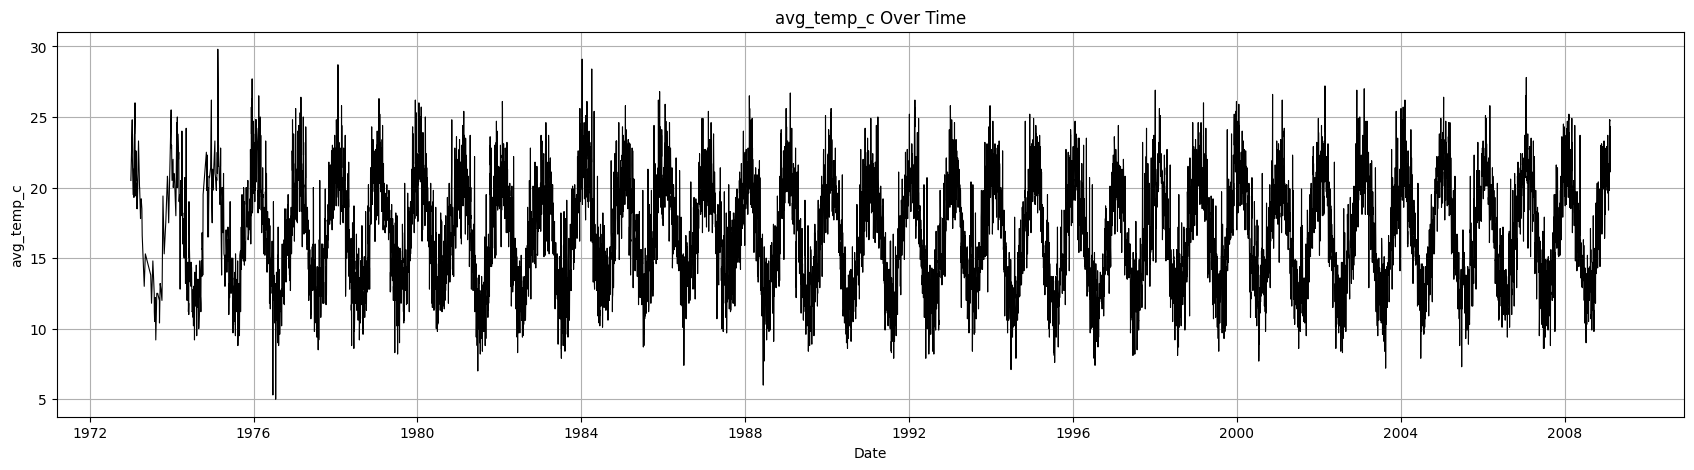

In [37]:
from util import plot_feature_over_time
plot_feature_over_time(raw_train, feature='avg_temp_c', dates=raw_train['DateTime'], shape=(21,5), save_path='../images/weather-over-time.pdf')

(12403, 10)
(12403,)
(12340, 64, 10)
(12340,)
Train indices from 0 to 1767 and validation indices from 1768 to 3529
Epoch [1/100], Loss: 304.9141, Validation Loss: 286.2989
Epoch [2/100], Loss: 287.1630, Validation Loss: 259.6376
Epoch [3/100], Loss: 246.4538, Validation Loss: 211.4238
Epoch [4/100], Loss: 198.5643, Validation Loss: 169.6627
Epoch [5/100], Loss: 163.5171, Validation Loss: 138.6612
Epoch [6/100], Loss: 135.9850, Validation Loss: 114.3622
Epoch [7/100], Loss: 113.0709, Validation Loss: 94.7762
Epoch [8/100], Loss: 95.3022, Validation Loss: 78.8410
Epoch [9/100], Loss: 80.2438, Validation Loss: 65.8284
Epoch [10/100], Loss: 67.8726, Validation Loss: 55.1797
Epoch [11/100], Loss: 58.0895, Validation Loss: 46.4814
Epoch [12/100], Loss: 48.8467, Validation Loss: 39.4033
Epoch [13/100], Loss: 42.3368, Validation Loss: 33.6791
Epoch [14/100], Loss: 36.9289, Validation Loss: 29.0684
Epoch [15/100], Loss: 33.1925, Validation Loss: 25.3838
Epoch [16/100], Loss: 29.2229, Validatio

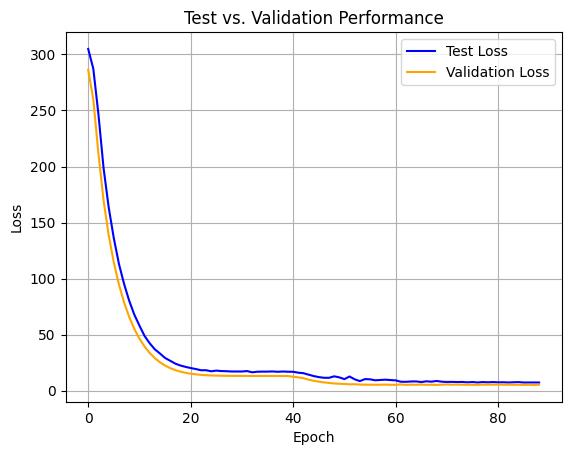

Train indices from 0 to 3529 and validation indices from 3530 to 5291
Epoch [1/100], Loss: 7.4492, Validation Loss: 4.8174
Epoch [2/100], Loss: 7.3865, Validation Loss: 4.9018
Epoch [3/100], Loss: 7.3922, Validation Loss: 5.0358
Epoch [4/100], Loss: 7.3829, Validation Loss: 4.9951
Epoch [5/100], Loss: 7.3421, Validation Loss: 4.8124
Epoch [6/100], Loss: 7.0278, Validation Loss: 4.8240
Epoch [7/100], Loss: 7.2980, Validation Loss: 4.7467
Epoch [8/100], Loss: 7.1607, Validation Loss: 4.7498
Epoch [9/100], Loss: 7.4386, Validation Loss: 4.7720
Epoch [10/100], Loss: 6.8471, Validation Loss: 4.7325
Epoch [11/100], Loss: 7.4501, Validation Loss: 4.7489
Epoch [12/100], Loss: 7.0546, Validation Loss: 4.7584
Epoch [13/100], Loss: 7.0741, Validation Loss: 4.7697
Epoch [14/100], Loss: 6.9567, Validation Loss: 4.7666
Epoch [15/100], Loss: 6.8978, Validation Loss: 4.7285
Epoch [16/100], Loss: 6.9992, Validation Loss: 4.7548
Epoch [17/100], Loss: 7.1865, Validation Loss: 4.7805
Epoch [18/100], Loss:

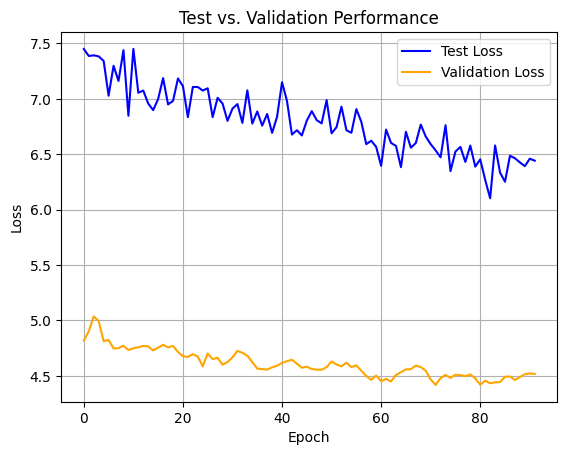

Train indices from 0 to 5291 and validation indices from 5292 to 7053
Epoch [1/100], Loss: 6.2479, Validation Loss: 4.1320
Epoch [2/100], Loss: 6.4498, Validation Loss: 3.9209
Epoch [3/100], Loss: 6.3014, Validation Loss: 3.7207
Epoch [4/100], Loss: 6.4023, Validation Loss: 3.6187
Epoch [5/100], Loss: 6.5084, Validation Loss: 3.5985
Epoch [6/100], Loss: 6.4784, Validation Loss: 3.6178
Epoch [7/100], Loss: 6.4682, Validation Loss: 3.7416
Epoch [8/100], Loss: 6.6032, Validation Loss: 3.8687
Epoch [9/100], Loss: 6.5444, Validation Loss: 3.8797
Epoch [10/100], Loss: 6.4478, Validation Loss: 3.9110
Epoch [11/100], Loss: 6.4776, Validation Loss: 4.0058
Epoch [12/100], Loss: 6.4629, Validation Loss: 3.9836
Epoch [13/100], Loss: 6.5892, Validation Loss: 3.9837
Epoch [14/100], Loss: 6.4394, Validation Loss: 3.9140
Epoch [15/100], Loss: 6.4418, Validation Loss: 3.9520
Epoch [16/100], Loss: 6.4710, Validation Loss: 3.8225
Epoch [17/100], Loss: 6.4850, Validation Loss: 3.7962
Epoch [18/100], Loss:

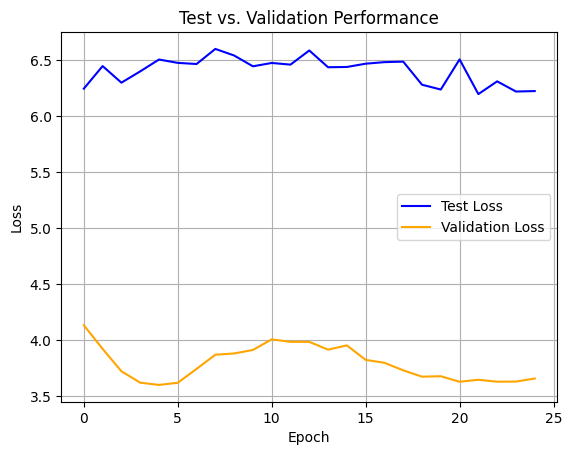

Train indices from 0 to 7053 and validation indices from 7054 to 8815
Epoch [1/100], Loss: 6.2968, Validation Loss: 5.4032
Epoch [2/100], Loss: 6.3752, Validation Loss: 4.8880
Epoch [3/100], Loss: 6.1517, Validation Loss: 4.8138
Epoch [4/100], Loss: 6.1018, Validation Loss: 4.6856
Epoch [5/100], Loss: 6.1346, Validation Loss: 4.5881
Epoch [6/100], Loss: 6.0682, Validation Loss: 4.5274
Epoch [7/100], Loss: 5.9902, Validation Loss: 4.6224
Epoch [8/100], Loss: 6.0247, Validation Loss: 4.5222
Epoch [9/100], Loss: 5.9300, Validation Loss: 4.4890
Epoch [10/100], Loss: 5.9985, Validation Loss: 4.4562
Epoch [11/100], Loss: 5.9154, Validation Loss: 4.4892
Epoch [12/100], Loss: 6.0261, Validation Loss: 4.4568
Epoch [13/100], Loss: 5.7499, Validation Loss: 4.3711
Epoch [14/100], Loss: 5.8699, Validation Loss: 4.3793
Epoch [15/100], Loss: 5.8307, Validation Loss: 4.4332
Epoch [16/100], Loss: 5.8991, Validation Loss: 4.3964
Epoch [17/100], Loss: 5.9061, Validation Loss: 4.3961
Epoch [18/100], Loss:

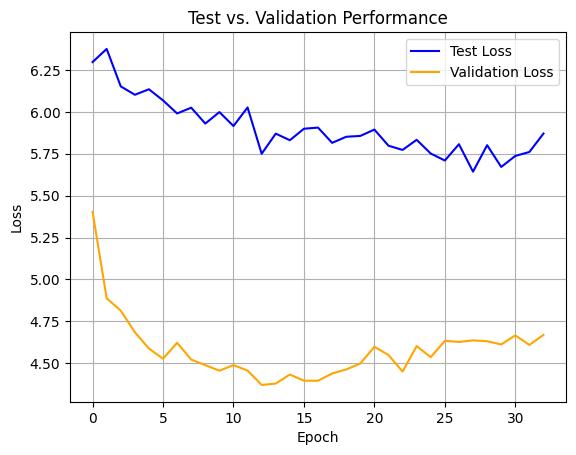

Train indices from 0 to 8815 and validation indices from 8816 to 10577
Epoch [1/100], Loss: 5.8198, Validation Loss: 4.3938
Epoch [2/100], Loss: 5.7894, Validation Loss: 4.4553
Epoch [3/100], Loss: 5.6767, Validation Loss: 4.4312
Epoch [4/100], Loss: 5.6467, Validation Loss: 4.4325
Epoch [5/100], Loss: 5.6165, Validation Loss: 4.4501
Epoch [6/100], Loss: 5.7983, Validation Loss: 4.4734
Epoch [7/100], Loss: 5.7459, Validation Loss: 4.3524
Epoch [8/100], Loss: 5.6027, Validation Loss: 4.4240
Epoch [9/100], Loss: 5.6418, Validation Loss: 4.3980
Epoch [10/100], Loss: 5.6398, Validation Loss: 4.4312
Epoch [11/100], Loss: 5.6612, Validation Loss: 4.4244
Epoch [12/100], Loss: 5.5963, Validation Loss: 4.3954
Epoch [13/100], Loss: 5.6390, Validation Loss: 4.3944
Epoch [14/100], Loss: 5.6034, Validation Loss: 4.3917
Epoch [15/100], Loss: 5.5814, Validation Loss: 4.4323
Epoch [16/100], Loss: 5.5500, Validation Loss: 4.4432
Epoch [17/100], Loss: 5.5302, Validation Loss: 4.4716
Epoch [18/100], Loss

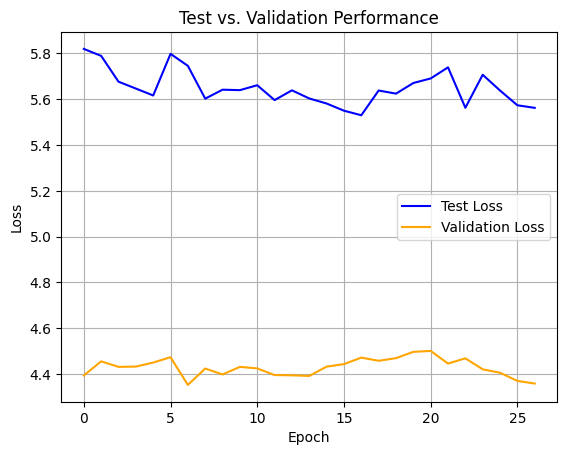

Train indices from 0 to 10577 and validation indices from 10578 to 12339
Epoch [1/100], Loss: 5.5360, Validation Loss: 3.8154
Epoch [2/100], Loss: 5.5279, Validation Loss: 3.8392
Epoch [3/100], Loss: 5.5456, Validation Loss: 3.9095
Epoch [4/100], Loss: 5.5623, Validation Loss: 3.8668
Epoch [5/100], Loss: 5.5724, Validation Loss: 3.8630
Epoch [6/100], Loss: 5.5280, Validation Loss: 3.8741
Epoch [7/100], Loss: 5.4527, Validation Loss: 3.7840


KeyboardInterrupt: 

In [33]:
from util import training, ElmanRNN

from sklearn.preprocessing import RobustScaler

elman_model_h32 = ElmanRNN(input_size=train_preprocessed.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2)

weather_elman_h32_results = training(model=elman_model_h32,
                             data=train_preprocessed,
                             batch_size=128,
                             optimizer_learning_rate=0.002,
                             optimizer_weight_decay=1e-5,
                             target_feature_name='avg_temp_c',
                             model_name='ElmanRNN_h32_weather',
                             splits=6,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=100)


In [ ]:


pickle.dump(weather_elman_h32_results, open( "../pickles/weather_elman_h32_results.pkl", "wb" ) )

(12403, 10)
(12403,)
(12340, 64, 10)
(12340,)
Train indices from 0 to 1767 and validation indices from 1768 to 3529
Epoch [1/100], Loss: 299.5729, Validation Loss: 278.4376
Epoch [2/100], Loss: 245.8077, Validation Loss: 208.4436
Epoch [3/100], Loss: 193.5256, Validation Loss: 167.5734
Epoch [4/100], Loss: 161.2186, Validation Loss: 139.4703
Epoch [5/100], Loss: 136.8344, Validation Loss: 117.4476
Epoch [6/100], Loss: 117.0525, Validation Loss: 99.3537
Epoch [7/100], Loss: 99.7141, Validation Loss: 84.2241
Epoch [8/100], Loss: 85.8169, Validation Loss: 71.5333
Epoch [9/100], Loss: 73.3627, Validation Loss: 60.8166
Epoch [10/100], Loss: 63.8653, Validation Loss: 51.8291
Epoch [11/100], Loss: 54.4099, Validation Loss: 44.3399
Epoch [12/100], Loss: 47.5444, Validation Loss: 38.1088
Epoch [13/100], Loss: 41.1799, Validation Loss: 32.9768
Epoch [14/100], Loss: 35.9144, Validation Loss: 28.7781
Epoch [15/100], Loss: 31.9240, Validation Loss: 25.3739
Epoch [16/100], Loss: 29.5720, Validation 

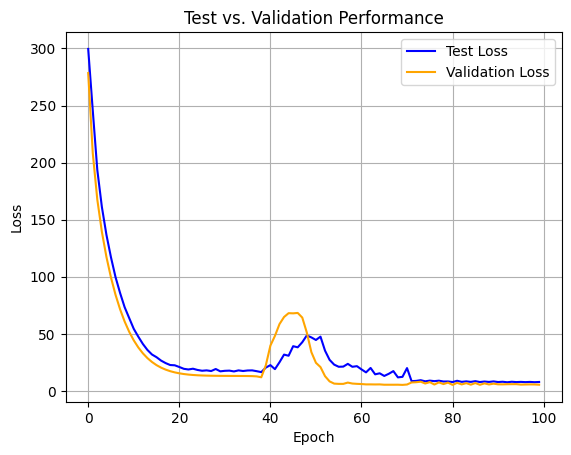

Train indices from 0 to 3529 and validation indices from 3530 to 5291
Epoch [1/100], Loss: 7.9860, Validation Loss: 4.6048
Epoch [2/100], Loss: 7.7791, Validation Loss: 4.6961
Epoch [3/100], Loss: 7.7052, Validation Loss: 4.7603
Epoch [4/100], Loss: 7.4646, Validation Loss: 4.9421
Epoch [5/100], Loss: 7.5818, Validation Loss: 5.1128
Epoch [6/100], Loss: 7.5344, Validation Loss: 5.4666
Epoch [7/100], Loss: 9.0581, Validation Loss: 5.3821
Epoch [8/100], Loss: 7.6693, Validation Loss: 5.2318
Epoch [9/100], Loss: 7.5326, Validation Loss: 4.8824
Epoch [10/100], Loss: 8.5244, Validation Loss: 4.6051
Epoch [11/100], Loss: 8.1652, Validation Loss: 4.5011
Epoch [12/100], Loss: 7.6474, Validation Loss: 4.5547
Epoch [13/100], Loss: 7.4801, Validation Loss: 4.6577
Epoch [14/100], Loss: 7.2591, Validation Loss: 4.7924
Epoch [15/100], Loss: 7.0718, Validation Loss: 4.6998
Epoch [16/100], Loss: 7.2071, Validation Loss: 4.6531
Epoch [17/100], Loss: 7.4211, Validation Loss: 4.6760
Epoch [18/100], Loss:

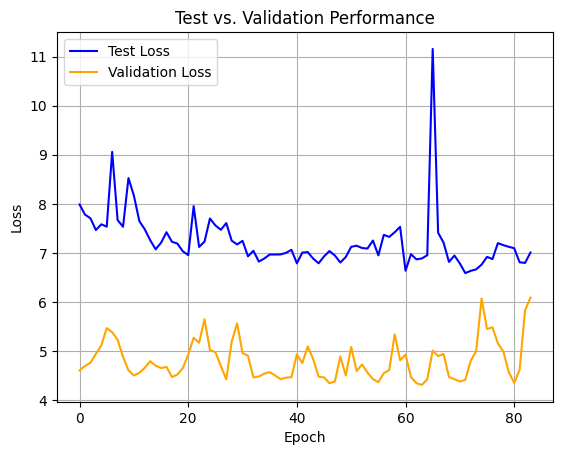

Train indices from 0 to 5291 and validation indices from 5292 to 7053
Epoch [1/100], Loss: 6.7941, Validation Loss: 3.8116
Epoch [2/100], Loss: 6.3305, Validation Loss: 4.4965
Epoch [3/100], Loss: 6.5635, Validation Loss: 4.6242
Epoch [4/100], Loss: 6.4575, Validation Loss: 5.3227
Epoch [5/100], Loss: 6.6053, Validation Loss: 5.7948
Epoch [6/100], Loss: 6.7598, Validation Loss: 7.2444
Epoch [7/100], Loss: 6.8539, Validation Loss: 6.9409
Epoch [8/100], Loss: 6.9086, Validation Loss: 8.2900
Epoch [9/100], Loss: 6.6828, Validation Loss: 9.3230
Epoch [10/100], Loss: 6.8280, Validation Loss: 10.2029
Epoch [11/100], Loss: 6.8828, Validation Loss: 9.2332
Epoch [12/100], Loss: 7.0104, Validation Loss: 9.6551
Epoch [13/100], Loss: 7.2724, Validation Loss: 7.8096
Epoch [14/100], Loss: 6.9256, Validation Loss: 7.1258
Epoch [15/100], Loss: 7.1616, Validation Loss: 6.2527
Epoch [16/100], Loss: 7.4589, Validation Loss: 5.0247
Epoch [17/100], Loss: 7.3642, Validation Loss: 4.4809
Epoch [18/100], Loss

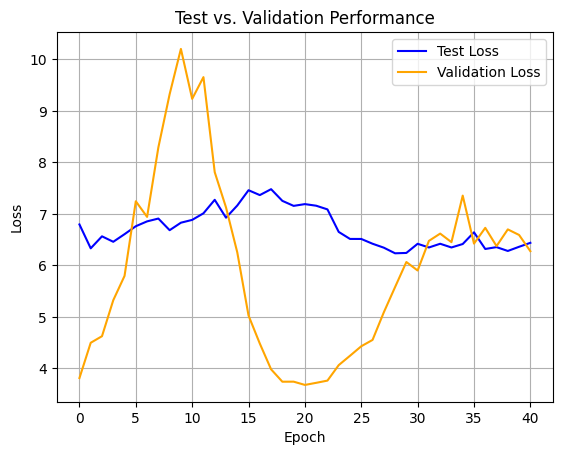

Train indices from 0 to 7053 and validation indices from 7054 to 8815
Epoch [1/100], Loss: 6.6077, Validation Loss: 5.5610
Epoch [2/100], Loss: 6.6249, Validation Loss: 5.3036
Epoch [3/100], Loss: 6.8821, Validation Loss: 4.7631
Epoch [4/100], Loss: 6.6099, Validation Loss: 4.7693
Epoch [5/100], Loss: 6.2566, Validation Loss: 4.2897
Epoch [6/100], Loss: 6.3107, Validation Loss: 4.3446
Epoch [7/100], Loss: 6.1459, Validation Loss: 4.2885
Epoch [8/100], Loss: 6.3477, Validation Loss: 4.3113
Epoch [9/100], Loss: 6.0042, Validation Loss: 4.3036
Epoch [10/100], Loss: 6.2368, Validation Loss: 4.3285
Epoch [11/100], Loss: 6.1303, Validation Loss: 4.3404
Epoch [12/100], Loss: 6.1605, Validation Loss: 4.3020
Epoch [13/100], Loss: 6.1013, Validation Loss: 4.3742
Epoch [14/100], Loss: 6.1151, Validation Loss: 4.3459
Epoch [15/100], Loss: 6.1280, Validation Loss: 4.2871
Epoch [16/100], Loss: 6.3030, Validation Loss: 4.8597
Epoch [17/100], Loss: 6.1888, Validation Loss: 4.6278
Epoch [18/100], Loss:

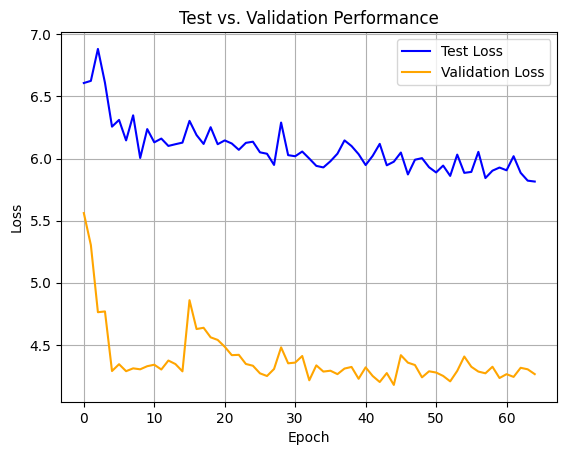

Train indices from 0 to 8815 and validation indices from 8816 to 10577
Epoch [1/100], Loss: 6.0632, Validation Loss: 4.4152
Epoch [2/100], Loss: 5.8985, Validation Loss: 4.4190
Epoch [3/100], Loss: 5.9021, Validation Loss: 4.3796
Epoch [4/100], Loss: 5.9453, Validation Loss: 4.3931
Epoch [5/100], Loss: 5.9288, Validation Loss: 4.4518
Epoch [6/100], Loss: 5.7877, Validation Loss: 4.5498
Epoch [7/100], Loss: 5.8278, Validation Loss: 4.4799
Epoch [8/100], Loss: 5.8919, Validation Loss: 4.4656
Epoch [9/100], Loss: 5.9109, Validation Loss: 4.4832
Epoch [10/100], Loss: 5.8839, Validation Loss: 4.4396
Epoch [11/100], Loss: 5.9595, Validation Loss: 4.4107
Epoch [12/100], Loss: 5.9410, Validation Loss: 4.4197
Epoch [13/100], Loss: 5.9297, Validation Loss: 4.4621
Epoch [14/100], Loss: 5.8566, Validation Loss: 4.4315
Epoch [15/100], Loss: 5.9632, Validation Loss: 4.5316
Epoch [16/100], Loss: 5.9538, Validation Loss: 4.3994
Epoch [17/100], Loss: 5.8020, Validation Loss: 4.4798
Epoch [18/100], Loss

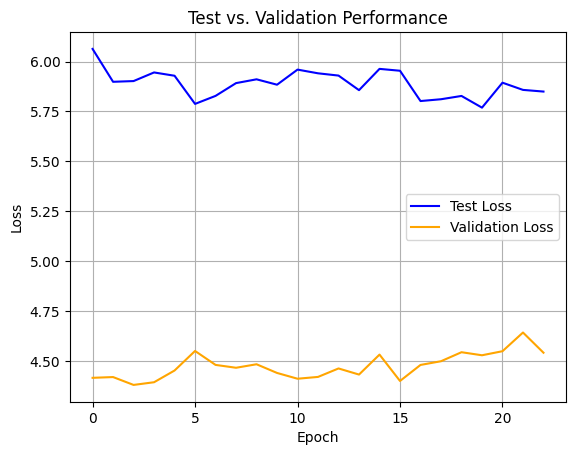

Train indices from 0 to 10577 and validation indices from 10578 to 12339
Epoch [1/100], Loss: 5.9124, Validation Loss: 3.7947
Epoch [2/100], Loss: 5.8256, Validation Loss: 3.7614
Epoch [3/100], Loss: 5.8029, Validation Loss: 3.7966
Epoch [4/100], Loss: 5.8516, Validation Loss: 3.8146
Epoch [5/100], Loss: 5.8105, Validation Loss: 3.9175
Epoch [6/100], Loss: 5.8198, Validation Loss: 3.7681
Epoch [7/100], Loss: 5.8062, Validation Loss: 3.8823
Epoch [8/100], Loss: 5.7585, Validation Loss: 3.8832
Epoch [9/100], Loss: 5.7789, Validation Loss: 3.9201
Epoch [10/100], Loss: 5.7817, Validation Loss: 3.8647
Epoch [11/100], Loss: 5.7953, Validation Loss: 3.9921
Epoch [12/100], Loss: 5.7814, Validation Loss: 4.0726
Epoch [13/100], Loss: 5.6677, Validation Loss: 3.9294
Epoch [14/100], Loss: 5.7469, Validation Loss: 3.9803
Epoch [15/100], Loss: 5.7777, Validation Loss: 3.9516
Epoch [16/100], Loss: 5.8000, Validation Loss: 4.0254
Epoch [17/100], Loss: 5.8100, Validation Loss: 4.1423
Epoch [18/100], Lo

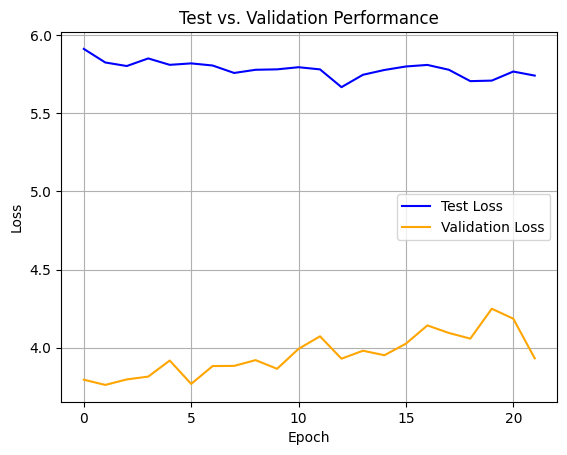

In [ ]:
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN

from sklearn.preprocessing import RobustScaler

jordan_model_h32 = JordanRNN(input_size=train_preprocessed.shape[1]-1, hidden_size=32, output_size=1, state_size=32, dropout=0.2)

weather_jordan_h32_results = training(model=jordan_model_h32,
                             data=train_preprocessed,
                             batch_size=128,
                             optimizer_learning_rate=0.002,
                             optimizer_weight_decay=1e-5,
                             target_feature_name='avg_temp_c',
                             model_name='JordanRNN_h32_weather',
                             splits=6,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=100)


In [ ]:
pickle.dump(weather_jordan_h32_results, open("../pickles/weather_jordan_h32_results.pkl", "wb" ))

NameError: name 'weather_jordan_h32_results' is not defined

In [ ]:
weather_elman_h32_results = pickle.load(open( "../pickles/weather_elman_h32_results.pkl", "rb" ))
weather_jordan_h32_results = pickle.load(open( "../pickles/weather_jordan_h32_results.pkl", "rb" ))

In [ ]:
weather_jordan_h32_results['cv_scores']

[5.279654145240784,
 4.308969037873404,
 3.677829282624381,
 4.177916577884129,
 4.37962714263371,
 3.7614268575395857]

In [ ]:
weather_elman_h32_results['cv_scores']

[4.956294570650373,
 4.499836325645447,
 3.5774979421070645,
 4.3134759323937555,
 4.398951240948269,
 3.6356785467692783]

(12403, 10)
(12403,)
(12340, 64, 10)
(12340,)
Train indices from 0 to 1767 and validation indices from 1768 to 3529
Epoch [1/100], Loss: 305.9841, Validation Loss: 295.5960
Epoch [2/100], Loss: 247.1134, Validation Loss: 198.9903
Epoch [3/100], Loss: 167.6644, Validation Loss: 129.3631
Epoch [4/100], Loss: 114.8358, Validation Loss: 86.5580
Epoch [5/100], Loss: 78.6982, Validation Loss: 57.6136
Epoch [6/100], Loss: 54.2120, Validation Loss: 38.7669
Epoch [7/100], Loss: 38.2538, Validation Loss: 27.2170
Epoch [8/100], Loss: 28.5959, Validation Loss: 20.4578
Epoch [9/100], Loss: 22.2786, Validation Loss: 16.7192
Epoch [10/100], Loss: 19.3417, Validation Loss: 14.7747
Epoch [11/100], Loss: 17.7158, Validation Loss: 13.8139
Epoch [12/100], Loss: 16.5870, Validation Loss: 13.3734
Epoch [13/100], Loss: 16.4690, Validation Loss: 13.2056
Epoch [14/100], Loss: 16.4862, Validation Loss: 13.1588
Epoch [15/100], Loss: 15.8760, Validation Loss: 13.1546
Epoch [16/100], Loss: 16.0764, Validation Loss

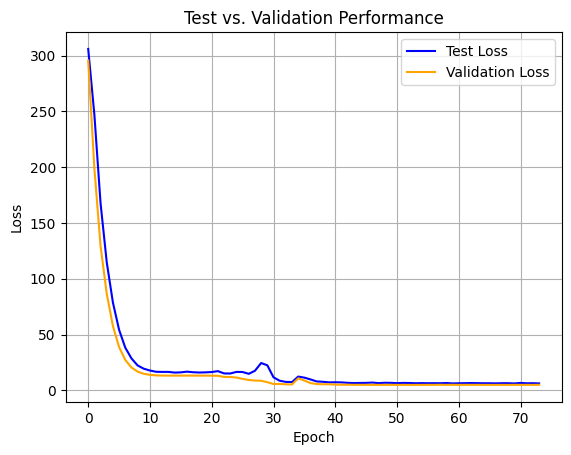

Train indices from 0 to 3529 and validation indices from 3530 to 5291
Epoch [1/100], Loss: 6.4406, Validation Loss: 4.8540
Epoch [2/100], Loss: 6.2245, Validation Loss: 4.6773
Epoch [3/100], Loss: 6.2710, Validation Loss: 4.6450
Epoch [4/100], Loss: 6.1794, Validation Loss: 4.7915
Epoch [5/100], Loss: 6.1559, Validation Loss: 4.8561
Epoch [6/100], Loss: 6.1492, Validation Loss: 4.9169
Epoch [7/100], Loss: 6.2791, Validation Loss: 5.3002
Epoch [8/100], Loss: 6.1970, Validation Loss: 5.3599
Epoch [9/100], Loss: 6.6728, Validation Loss: 5.6882
Epoch [10/100], Loss: 6.1555, Validation Loss: 5.6416
Epoch [11/100], Loss: 6.3366, Validation Loss: 5.8975
Epoch [12/100], Loss: 6.4722, Validation Loss: 6.1326
Epoch [13/100], Loss: 6.5386, Validation Loss: 5.7062
Epoch [14/100], Loss: 6.8562, Validation Loss: 5.8658
Epoch [15/100], Loss: 7.1479, Validation Loss: 5.5701
Epoch [16/100], Loss: 6.8251, Validation Loss: 5.5259
Epoch [17/100], Loss: 7.0351, Validation Loss: 5.2496
Epoch [18/100], Loss:

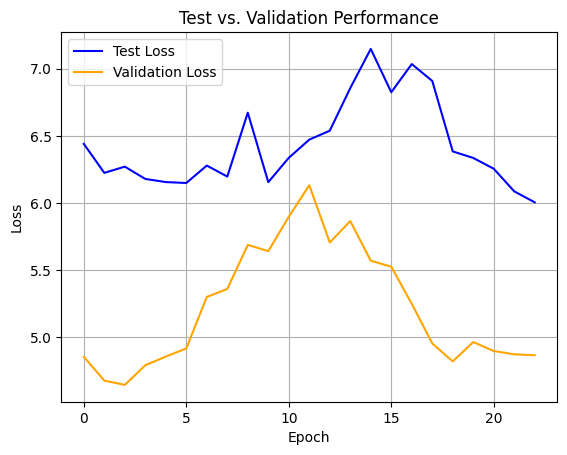

Train indices from 0 to 5291 and validation indices from 5292 to 7053
Epoch [1/100], Loss: 12.0372, Validation Loss: 4.2417
Epoch [2/100], Loss: 6.0355, Validation Loss: 4.1602
Epoch [3/100], Loss: 6.3072, Validation Loss: 4.1904
Epoch [4/100], Loss: 6.1499, Validation Loss: 4.2499
Epoch [5/100], Loss: 6.2418, Validation Loss: 4.4364
Epoch [6/100], Loss: 6.3096, Validation Loss: 4.7510
Epoch [7/100], Loss: 6.2000, Validation Loss: 5.3806
Epoch [8/100], Loss: 6.1481, Validation Loss: 5.3553
Epoch [9/100], Loss: 6.1814, Validation Loss: 5.7391
Epoch [10/100], Loss: 6.2968, Validation Loss: 6.1102
Epoch [11/100], Loss: 6.2660, Validation Loss: 6.3745
Epoch [12/100], Loss: 6.1728, Validation Loss: 6.6133
Epoch [13/100], Loss: 6.2160, Validation Loss: 6.5010
Epoch [14/100], Loss: 6.1834, Validation Loss: 7.2969
Epoch [15/100], Loss: 5.9745, Validation Loss: 7.1467
Epoch [16/100], Loss: 6.0307, Validation Loss: 7.0388
Epoch [17/100], Loss: 5.9780, Validation Loss: 7.7756
Epoch [18/100], Loss

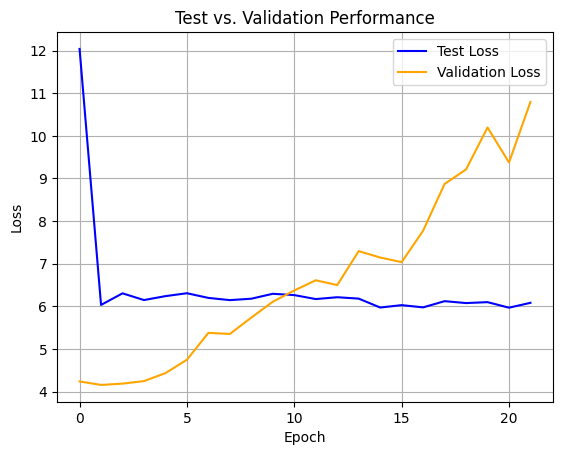

Train indices from 0 to 7053 and validation indices from 7054 to 8815
Epoch [1/100], Loss: 5.8081, Validation Loss: 4.9477
Epoch [2/100], Loss: 5.9630, Validation Loss: 5.7061
Epoch [3/100], Loss: 6.1636, Validation Loss: 5.9875
Epoch [4/100], Loss: 6.3124, Validation Loss: 5.3774
Epoch [5/100], Loss: 6.1597, Validation Loss: 5.2745
Epoch [6/100], Loss: 6.0576, Validation Loss: 5.1671
Epoch [7/100], Loss: 6.0644, Validation Loss: 5.1460
Epoch [8/100], Loss: 6.0101, Validation Loss: 4.9552
Epoch [9/100], Loss: 5.8284, Validation Loss: 4.9762
Epoch [10/100], Loss: 5.8991, Validation Loss: 4.7936
Epoch [11/100], Loss: 5.7610, Validation Loss: 4.8786
Epoch [12/100], Loss: 5.6738, Validation Loss: 4.6755
Epoch [13/100], Loss: 5.7419, Validation Loss: 4.8384
Epoch [14/100], Loss: 5.8074, Validation Loss: 4.7904
Epoch [15/100], Loss: 5.7622, Validation Loss: 4.6801
Epoch [16/100], Loss: 5.6500, Validation Loss: 4.5278
Epoch [17/100], Loss: 5.5750, Validation Loss: 4.5848
Epoch [18/100], Loss:

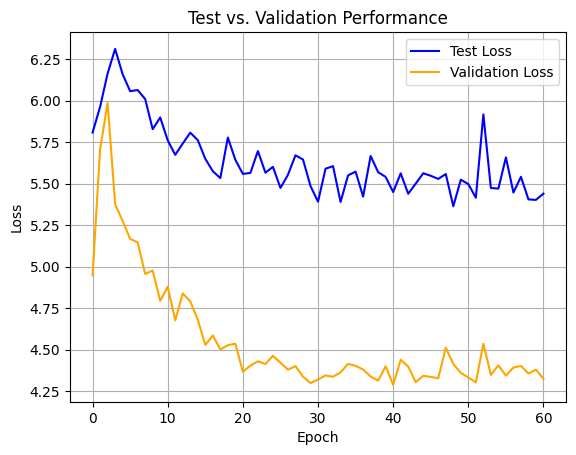

Train indices from 0 to 8815 and validation indices from 8816 to 10577
Epoch [1/100], Loss: 5.4729, Validation Loss: 4.4222
Epoch [2/100], Loss: 5.4966, Validation Loss: 4.4549
Epoch [3/100], Loss: 5.4416, Validation Loss: 4.4538
Epoch [4/100], Loss: 5.2670, Validation Loss: 4.4567
Epoch [5/100], Loss: 5.4531, Validation Loss: 4.4458
Epoch [6/100], Loss: 5.4646, Validation Loss: 4.4289
Epoch [7/100], Loss: 5.3934, Validation Loss: 4.4387
Epoch [8/100], Loss: 5.4520, Validation Loss: 4.3948
Epoch [9/100], Loss: 5.3823, Validation Loss: 4.4380
Epoch [10/100], Loss: 5.3543, Validation Loss: 4.3928
Epoch [11/100], Loss: 5.3118, Validation Loss: 4.4174
Epoch [12/100], Loss: 5.3215, Validation Loss: 4.4837
Epoch [13/100], Loss: 5.3086, Validation Loss: 4.4305
Epoch [14/100], Loss: 5.4196, Validation Loss: 4.4327
Epoch [15/100], Loss: 5.2730, Validation Loss: 4.3888
Epoch [16/100], Loss: 5.3277, Validation Loss: 4.4077
Epoch [17/100], Loss: 5.3242, Validation Loss: 4.3966
Epoch [18/100], Loss

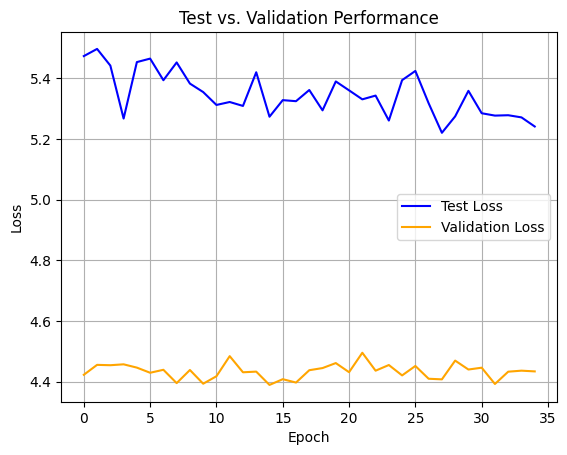

Train indices from 0 to 10577 and validation indices from 10578 to 12339
Epoch [1/100], Loss: 5.3407, Validation Loss: 3.7284
Epoch [2/100], Loss: 5.2951, Validation Loss: 3.7171
Epoch [3/100], Loss: 5.2532, Validation Loss: 3.7098
Epoch [4/100], Loss: 5.3596, Validation Loss: 3.7022
Epoch [5/100], Loss: 5.3011, Validation Loss: 3.6674
Epoch [6/100], Loss: 5.2350, Validation Loss: 3.6653
Epoch [7/100], Loss: 5.1444, Validation Loss: 3.6794
Epoch [8/100], Loss: 5.2389, Validation Loss: 3.6735
Epoch [9/100], Loss: 5.2797, Validation Loss: 3.6929
Epoch [10/100], Loss: 5.3283, Validation Loss: 3.6678
Epoch [11/100], Loss: 5.3182, Validation Loss: 3.6725
Epoch [12/100], Loss: 5.2476, Validation Loss: 3.6603
Epoch [13/100], Loss: 5.3009, Validation Loss: 3.6716
Epoch [14/100], Loss: 5.1343, Validation Loss: 3.6557
Epoch [15/100], Loss: 5.1682, Validation Loss: 3.6383
Epoch [16/100], Loss: 5.1722, Validation Loss: 3.6340
Epoch [17/100], Loss: 5.2650, Validation Loss: 3.6392
Epoch [18/100], Lo

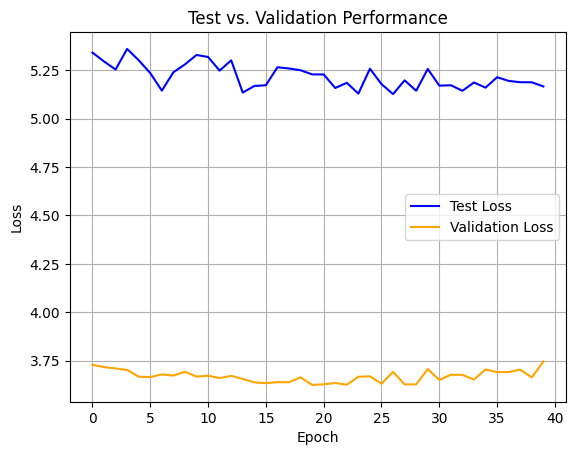

In [ ]:
from util import training, ElmanRNN

from sklearn.preprocessing import RobustScaler

elman_model_h64 = ElmanRNN(input_size=train_preprocessed.shape[1]-1, hidden_size=64, output_size=1, dropout=0.2)

weather_elman_h64_results = training(model=elman_model_h64,
                             data=train_preprocessed,
                             batch_size=128,
                             optimizer_learning_rate=0.002,
                             optimizer_weight_decay=1e-5,
                             target_feature_name='avg_temp_c',
                             model_name='ElmanRNN_h64_weather',
                             splits=6,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=100)


In [ ]:
pickle.dump(weather_elman_h32_results, open( "../pickles/weather_elman_h32_results.pkl", "wb" ))
pickle.dump(weather_jordan_h32_results, open( "../pickles/weather_jordan_h32_results.pkl", "wb" ) )
pickle.dump(weather_elman_h64_results, open( "../pickles/weather_elman_h64_results.pkl", "wb" ))

In [5]:
weather_jordan_h32_results = pickle.load( open( "../pickles/weather_jordan_h32_results.pkl", "rb" ))
weather_elman_h32_results = pickle.load( open( "../pickles/weather_elman_h32_results.pkl", "rb" ))

In [ ]:
from util import get_predictions
processed_test = preprocess(raw_test)
r1 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=weather_jordan_h32_results, 
                     model_name='JordanRNN H32 Weather',
                     xlabel='Date',
                     ylabel='Average Temperature (C)',
                     title='Actual vs Predicted Average Temperature on Test Set',
                     target_feature_name='avg_temp_c',
                     save_path='../images/weather-jordan-h32-actual-vs-predicted.pdf')
r2 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=weather_elman_h32_results, 
                     model_name='ElmanRNN H32 Weather',
                     xlabel='Date',
                     ylabel='Average Temperature (C)',
                     target_feature_name='avg_temp_c',
                     title='Actual vs Predicted Average Temperature on Test Set',
                     save_path='../images/weather-elman-h32-actual-vs-predicted.pdf')
results = pd.concat([r1, r2])
results.round(2).to_csv('../csv-descriptions/weather-rnn-results.csv', index=False)
results.round(2)

TypeError: get_predictions() missing 1 required positional argument: 'target_feature_name'